In [1]:
import sys
sys.executable

'D:\\AI Training\\MyVirtualEnv\\env\\Scripts\\python.exe'

## How to build a web crawler

How to build a web crawler
Acquiring data in text form is the first step to use embeddings. This tutorial creates a new set of data by crawling the OpenAI website, a technique that you can also use for your own company or personal website.

This crawler will start from the root URL passed in at the bottom of the code below, visit each page, find additional links, and visit those pages as well (as long as they have the same root domain).

To begin, import the required packages, set up the basic URL, and define a HTMLParser class.

In [2]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse, unquote
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "openai.com" # <- put your domain to be crawled
full_url = "https://openai.com/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

The next function takes a URL as an argument, opens the URL, and reads the HTML content. Then, it returns all the hyperlinks found on that page.

In [3]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):

    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

The goal is to crawl through and index only the content that lives under the OpenAI domain. For this purpose, a function that calls the get_hyperlinks function but filters out any URLs that are not part of the specified domain is needed.

In [4]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

The crawl function is the final step in the web scraping task setup. It keeps track of the visited URLs to avoid repeating the same page, which might be linked across multiple pages on a site. It also extracts the raw text from a page without the HTML tags, and writes the text content into a local .txt file specific to the page.

In [5]:
def get_valid_filename(url):
    parsed_url = urlparse(url)
    path_segments = [segment for segment in parsed_url.path.split('/') if segment]
    unquoted_segments = [unquote(segment) for segment in path_segments]
    return '_'.join(unquoted_segments)

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create directories if they don't exist
    os.makedirs("text/" + local_domain, exist_ok=True)
    os.makedirs("processed", exist_ok=True)

    # # Create a directory to store the text files
    # if not os.path.exists("text/"):
    #         os.mkdir("text/")

    # if not os.path.exists("text/"+local_domain+"/"):
    #         os.mkdir("text/" + local_domain + "/")

    # # Create a directory to store the csv files
    # if not os.path.exists("processed"):
    #         os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Generate a valid file name from the URL
        file_name = get_valid_filename(url)
        file_path = os.path.join("text", local_domain, file_name + ".txt")

        # Save text from the url to a <url>.txt file
        with open(file_path, "w", encoding="UTF-8") as f:
        # with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            else:
                # Otherwise, write the text to the file in the text directory
                f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://openai.com/
https://openai.com/chatgpt
https://openai.com/blog/dall-e-3-is-now-available-in-chatgpt-plus-and-enterprise
https://openai.com/blog?topics=product
https://openai.com/blog/new-models-and-developer-products-announced-at-devday
https://openai.com/blog/new-models-and-developer-products-announced-at-devday#content
https://openai.com/enterprise-privacy
https://openai.com/enterprise-privacy#content
https://openai.com/contact-sales
https://openai.com/contact-sales#content
https://openai.com/enterprise
https://openai.com/chatgpt/enterprise#content
https://openai.com/blog/bug-bounty-program
https://openai.com/careers/search?c=security
https://openai.com/careers/software-engineer-infrastructure-2
https://openai.com/careers/search
https://openai.com/careers/software-engineer-infrastructure-2#content
https://openai.com/careers/stream-infrastructure-engineer
https://openai.com/careers/stream-infrastructure-engineer#content
https://openai.com/careers/full-stack-engineer-leverage-e

## Building an embeddings index¶

CSV is a common format for storing embeddings. You can use this format with Python by converting the raw text files (which are in the text directory) into Pandas data frames. Pandas is a popular open source library that helps you work with tabular data (data stored in rows and columns).

Blank empty lines can clutter the text files and make them harder to process. A simple function can remove those lines and tidy up the files.

In [6]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

Converting the text to CSV requires looping through the text files in the text directory created earlier. After opening each file, remove the extra spacing and append the modified text to a list. Then, add the text with the new lines removed to an empty Pandas data frame and write the data frame to a CSV file.

Extra spacing and new lines can clutter the text and complicate the embeddings process. The code used here helps to remove some of them but you may find 3rd party libraries or other methods useful to get rid of more unnecessary characters.

In [12]:
!pip install --upgrade pandas

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
    --------------------------------------- 0.2/11.6 MB 7.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/11.6 MB 15.0 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.6 MB 15.1 MB/s eta 0:00:01
   --------- ------------------------------ 2.9/11.6 MB 16.7 MB/s eta 0:00:01
   ------------- -------------------------- 3.9/11.6 MB 16.5 MB/s eta 0:00:01
   ---------------- ----------------------- 4.9/11.6 MB 17.5 MB/s eta 0:00:01
   --------------------- ------------------ 6.2/11.6 MB 19.9 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.6 MB 19.0 MB/s eta 0:00:01
   ---------------------------- ----------- 8.4/11.6 MB 19.9 MB/s eta 0:00:01
   ---------------------------------- ----- 9.9/11.6 MB 21.1 MB/s eta 0:00:01

In [13]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,,. OpenAI CloseSearch Submit Skip to main c...
1,,. About CloseSearch Submit Skip to main co...
2,,. Safety & responsibility CloseSearch Subm...
3,,. Product CloseSearch Submit Skip to main ...
4,,. Pricing CloseSearch Submit Skip to main ...


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fname   445 non-null    object
 1   text    445 non-null    object
dtypes: object(2)
memory usage: 7.1+ KB


### Tokenization

Tokenization is the next step after saving the raw text into a CSV file. This process splits the input text into tokens by breaking down the sentences and words.

A helpful rule of thumb is that one token generally corresponds to ~4 characters of text for common English text. This translates to roughly ¾ of a word (so 100 tokens ~= 75 words).

The API has a limit on the maximum number of input tokens for embeddings. To stay below the limit, the text in the CSV file needs to be broken down into multiple rows. The existing length of each row will be recorded first to identify which rows need to be split.

The new model, text-embedding-ada-002, replaces five separate models for text search, text similarity, and code search, and outperforms our previous most capable model, Davinci, at most tasks, while being priced 99.8% lower.

Embeddings are numerical representations of concepts converted to number sequences, which make it easy for computers to understand the relationships between those concepts.

Stronger performance. text-embedding-ada-002 outperforms all the old embedding models on text search, code search, and sentence similarity tasks and gets comparable performance on text classification.

In [15]:
!pip install tiktoken

In [16]:
!pip show tiktoken

Name: tiktoken
Version: 0.6.0
Summary: tiktoken is a fast BPE tokeniser for use with OpenAI's models
Home-page: 
Author: Shantanu Jain
Author-email: shantanu@openai.com
License: MIT License

Copyright (c) 2022 OpenAI, Shantanu Jain

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN 

In [17]:
!where python

D:\AI Training\MyVirtualEnv\env\Scripts\python.exe
C:\Users\sonya\AppData\Local\Programs\Python\Python311\python.exe
C:\Users\sonya\AppData\Local\Microsoft\WindowsApps\python.exe


In [22]:
!pip install matplotlib

  Using cached contourpy-1.2.0-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.6 kB ? eta -:--:--
     ----------------------------------- -- 153.6/162.6 kB 3.1 MB/s eta 0:00:01
     -------------------------------------- 162.6/162.6 kB 2.5 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.6 MB 17.4 MB/s eta 0:00:01
   ----------- ---------------------------- 2.1/7.6 MB 19.5 MB/s eta 0:00:01
   ----------------- ---------------------- 3.3/7.6 MB 23.8 MB/s eta 0:00:01
   ---------------------- ----------------- 4.2/7.6 MB 20.9 MB/s eta 0:00:01
   -------------------------- ------------- 5.1/7.6 MB 20.4 MB/s eta 0:00:01
   ------------------------------- -------- 6.0/7.6 MB 20.2 MB/s eta 0:00:01
   ------------------

<Axes: >

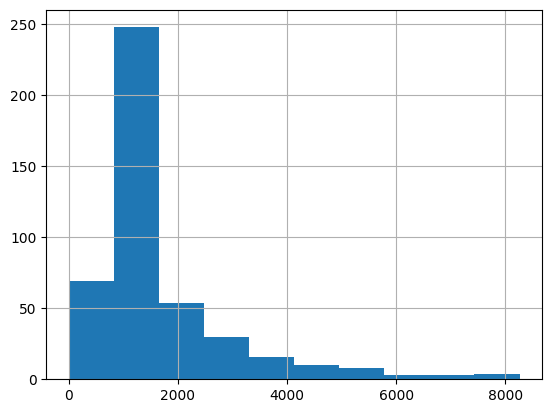

In [23]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

The newest embeddings model can handle inputs with up to 8191 input tokens so most of the rows would not need any chunking, but this may not be the case for every subpage scraped so the next code chunk will split the longer lines into smaller chunks.

In [24]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

Visualizing the updated histogram again can help to confirm if the rows were successfully split into shortened sections.

<Axes: >

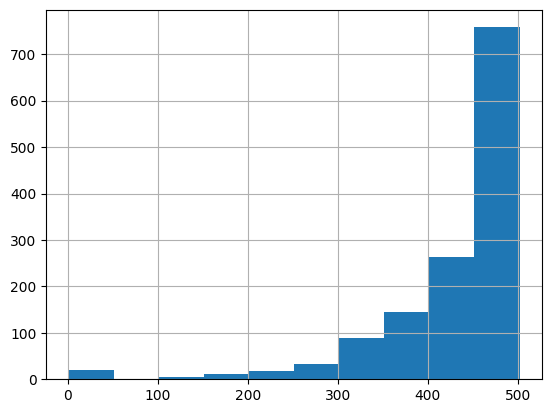

In [25]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

The content is now broken down into smaller chunks and a simple request can be sent to the OpenAI API specifying the use of the new text-embedding-ada-002 model to create the embeddings:

In [15]:
#!pip install openai

In [16]:
#!pip uninstall openai

^C


In [17]:
#import openai
#print(openai.__version__)

In [35]:
# from openai import OpenAI
# import os
# import pandas as pd

# client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
# model_name = 'text-embedding-ada-002'
# response = client.embeddings.create(input='your_text_here', model=model_name)
# embedding = response.data[0].embedding  # Assuming 'embedding' is a property of the response object
# df['embeddings'] = df.text.apply(lambda x: client.embeddings.create(input=x, model=model_name).data[0].embedding)
# df.to_csv('processed/embeddings.csv')
# df.head()

In [39]:
import time
from openai import OpenAI
import os
import pandas as pd

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
model_name = 'text-embedding-ada-002'

# Function to handle RateLimitError
def get_embeddings_with_retry(text):
    try:
        response = client.embeddings.create(input=text, model=model_name)
        return response.data[0].embedding
    except Exception as e:
        if "Rate limit reached" in str(e):
            wait_time = int(e.response.headers["Retry-After"])
            print(f"Rate limit reached. Waiting for {wait_time} seconds before retrying...")
            time.sleep(wait_time)
            return get_embeddings_with_retry(text)
        else:
            print(f"An error occurred: {e}")
            return None

# Apply the function to the DataFrame
df['embeddings'] = df.text.apply(get_embeddings_with_retry)

df.to_csv('processed/embeddings.csv')
df.head()


Rate limit reached. Waiting for 20 seconds before retrying...
Rate limit reached. Waiting for 432 seconds before retrying...
Rate limit reached. Waiting for 20 seconds before retrying...
Rate limit reached. Waiting for 432 seconds before retrying...
Rate limit reached. Waiting for 20 seconds before retrying...
Rate limit reached. Waiting for 432 seconds before retrying...
Rate limit reached. Waiting for 20 seconds before retrying...
Rate limit reached. Waiting for 432 seconds before retrying...
Rate limit reached. Waiting for 20 seconds before retrying...
Rate limit reached. Waiting for 432 seconds before retrying...
Rate limit reached. Waiting for 20 seconds before retrying...
Rate limit reached. Waiting for 432 seconds before retrying...


KeyboardInterrupt: 

In [19]:
!pip show openai

Name: openai
Version: 0.26.1
Summary: Python client library for the OpenAI API
Home-page: https://github.com/openai/openai-python
Author: OpenAI
Author-email: support@openai.com
License: 
Location: D:\AI Training\MyVirtualEnv\env\Lib\site-packages
Requires: aiohttp, requests, tqdm
Required-by: 


In [ ]:
!pip uninstall openai

In [22]:
!where openai

D:\AI Training\MyVirtualEnv\env\Scripts\openai.exe


In [1]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!cd

D:\AI Training\MyVirtualEnv\env\Scripts
